# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft) tension constraint.

Note: the form of the soft tension constraint used is very important. The constraint we use here is based on oriented triangle normals and at once fixes the angles in the cell array and prevents invalid mesh configurations.

Finally, we also provide code to handle intercalations.

In [ ]:
#| default_exp isogonal

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize

from tqdm.notebook import tqdm

from copy import copy, deepcopy
import pickle

In [ ]:
#| export
from dataclasses import dataclass

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

## Subclassing

As before in notebook `01`, we sub-class the `HalfEdgeMesh` (or rather, `TensionHalfEdgeMesh`) to add the methods and attributes required for primal cell shape optimization. This makes for cleaner overall design and reduces the previous reliance on `@patch` to modify the behavior of the base class dynamically (which has bad side effects, such as making module behavior dependent on import oder).

We first subclass the `Vertex` class to add an attribute for the reference shape (as shape tensor). If you wanted, you could also add attributes such as a reference area etc. This is currently not done, but could be added in the same manner.

In [ ]:
#| export

@dataclass
class CellVertex(msh.Vertex):
    """Vertex with attributes for primal shape optimization: rest_shape, 2x2 matrix of reference shape.""" 
    rest_shape = np.array([[1.0, 0.0], [0.0, 1.0]])
    
    def __repr__(self):
        return super().__repr__().replace('Vertex', 'CellVertex')
        
    def unwrap(self, in_place=True):
        """Cast to Vertex base class."""
        v = self if in_place else copy(self)
        v.__class__ = msh.Vertex
        del v.rest_shape
        if not in_place:
            return v
        
@patch
def wrap_as_CellVertex(self: msh.Vertex, rest_shape=np.array([[1.0, 0.0], [0.0, 1.0]]), in_place=True
                       ) -> Union[None, CellVertex]:
    """
    In-place/copy upcast from Vertex to CellVertex.
    
    Internal, for use in CellHalfEdgeMesh.__init__.
    """
    v = self if in_place else copy(self)
    v.__class__ = CellVertex
    v.rest_shape = rest_shape
    if not in_place:
        return v

In [ ]:
mesh = msh.get_test_hemesh_large()
v = mesh.vertices[10]
cv = v.wrap_as_CellVertex(in_place=False)

v, cv

(Vertex(vid=10, coords=[0.4 0. ], incident hes=[53, 11, 7057, 54]),
 CellVertex(vid=10, coords=[0.4 0. ], incident hes=[53, 11, 7057, 54]))

In [ ]:
#| export

class CellHalfEdgeMesh(tns.TensionHalfEdgeMesh):
    """
    HalfEdgeMesh with methods for cell shape optimization & active triangulation dynamics.
    
    Can be instantiated from a HalfEdgeMesh or ListOfVerticesAndFaces.
    """
    def __new__(cls, mesh: Union[None, msh.HalfEdgeMesh, tns.TensionHalfEdgeMesh]= None):
        if isinstance(mesh, msh.HalfEdgeMesh):
            mesh = tns.TensionHalfEdgeMesh(mesh)
            mesh.__class__ = cls
            return mesh
        return super().__new__(cls)
    def __init__(self, mesh: Union[msh.ListOfVerticesAndFaces, msh.HalfEdgeMesh]):
        super().__init__(mesh)
        for v in self.vertices.values():
            v.wrap_as_CellVertex(in_place=True)
            
    def save_mesh(self, fname: str, save_attribs=False) -> None:
        super().save_mesh(fname, save_rest_passive=save_attribs)
        if save_attribs:
            pickle.dump({key: val.rest_shape for key, val in self.vertices.items()},
                        open(f"{fname}_rest_shape.p", "wb"))
    save_mesh.__doc__ = (msh.HalfEdgeMesh.save_mesh.__doc__
                         +'\n Can also pickle passive, rest & rest_shape attributes as dicts at fname_{...}.p')
    
    def unwrap(self):
        """In-place cast to HalfEdgeMesh base class."""
        self.__class__ = msh.HalfEdgeMesh
        for v in self.vertices.values():
            v.unwrap(in_place=True)
        for he in self.hes.values():
            he.unwrap(in_place=True)

    @staticmethod
    def load_mesh(fname: str, load_attribs=False):
        """
        Load from file as saved by mesh.save_mesh.
        
        Can load rest/passive attributes of half edges & rest shapes of vertices,
        if saved as pickled dicts at fname_{...}.p
        """
        mesh = CellHalfEdgeMesh(super(tns.TensionHalfEdgeMesh, tns.TensionHalfEdgeMesh).load_mesh(fname))
        if load_attribs:
            rest_dict = pickle.load(open(f'{fname}_rest.p', 'rb'))
            passive_dict = pickle.load(open(f'{fname}_passive.p', 'rb'))
            for key, he in mesh.hes.items():
                he.rest = rest_dict[key]
                he.passive = passive_dict[key]
        return mesh

In [ ]:
mesh = msh.get_test_hemesh_large()
tmesh = tns.TensionHalfEdgeMesh(mesh)

In [ ]:
cmesh = CellHalfEdgeMesh(mesh)
# can be a little slow (200 ms) because we need to iterate over vertices and promote them to CellVertices
cmesh1 = CellHalfEdgeMesh(mesh.to_ListOfVerticesAndFaces())

print(cmesh.is_consistent())
print(cmesh1.is_consistent())

True
True


In [ ]:
#cmesh.vertices[19], cmesh.faces[2].hes[0]

(CellVertex(vid=19, coords=[0.8 0. ], incident hes=[1023, 2657, 7122, 1028, 2651]),
 TensionHalfEdge(heid=6, nxt=7, prev=8, twin=248, face=2, vertices=(12, 37), center=[0.5 0. ])

## Primal shape energy

To compute the position of the cell vertices, we minimize a form of elastic energy under the angle constraints imposed by the triangulation. Here, we create a few methods related to the shape elastic energy, in particular computing the shape tensor, and then proceed to a JAX-based implementation of elastic energy minimization. Similar to the routines for triangulation vertex optimization, this involves serializing the mesh into a bunch of arrays. All of this is then wrapped into a convenient class method that can be used in the simulation loop.

In [ ]:
#| export

def get_shape_tensor(poly: NDArray[Shape["*,2,..."],Float], epsilon_l=1e-4) -> NDArray[Shape["2,2,..."],Float]:
    """
    Compute shape tensor from polygon vertex coords.
    
    Assumes that the vertex coords are order clock- or counter-clockwise.
    Computes Sum_e l_e \outer l_e / |l_e| where l_e is the vector along
    polygon e.
    
    Parameters
    ----------
    poly : (n_vertices, 2, n_samples) array
        Input polygon(s)
    epsilon_l : float
        Regularization to keep function diff'ble for 0-edge length polygons
        
    Returns
    -------
    (2, 2, n_samples) array
        Shape tensor
    """

    edges = poly - jnp.roll(poly, 1, axis=0)
    lengths = jnp.sqrt(jnp.sum(edges**2, axis=1)+epsilon_l**2) # to make differentiable
    units = (edges.swapaxes(1,0)/lengths).swapaxes(1,0)
    return jnp.einsum('ei...,ej...->ij...', edges, units)
    
@patch
def get_vrtx_shape_tensor(self: CellVertex) -> NDArray[Shape["2,2"],Float]:
    """Get shape tensor for a vertex (=primal cell) using get_shape_tensor. Returns Id for bdry vertices."""
    neighbors = self.get_face_neighbors()
    if (None in neighbors) or self is None:
        return np.eye(2)
    cell = np.stack([fc.dual_coords for fc in neighbors])
    return get_shape_tensor(cell)

@patch
def set_rest_shapes(self: CellHalfEdgeMesh) -> None:
    """Set rest shape for all mesh vertices to current shape tensor."""
    for v in self.vertices.values():
        v.rest_shape = v.get_vrtx_shape_tensor()

In [ ]:
square = np.array([[0,0],[1,0],[1,1],[0,1]])
print(square.shape)
print(get_shape_tensor(square))

squares = np.stack(10*[square,], axis=-1)
print(squares.shape)
print(get_shape_tensor(squares).shape)

(4, 2)
[[1.99999999 0.        ]
 [0.         1.99999999]]
(4, 2, 10)
(2, 2, 10)


In [ ]:
mesh = CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()

print(mesh.vertices[15].get_vrtx_shape_tensor())
mesh.set_rest_shapes()
print(mesh.vertices[15].rest_shape)

[[1.73205078e+00 5.55111512e-17]
 [4.82592660e-17 1.73205078e+00]]
[[1.73205078e+00 5.55111512e-17]
 [4.82592660e-17 1.73205078e+00]]


In [ ]:
tns.polygon_area(square)

DeviceArray(-1., dtype=float64)

In [ ]:
#| export

def get_shape_energy(poly: NDArray[Shape["*,2"],Float],
                     rest_shape: NDArray[Shape["2,2"],Float]=jnp.eye(2), A0=jnp.sqrt(3)/2,
                     mod_shear=.5, mod_bulk=1, mod_area=0) -> float:
    """
    Compute shape tensor energy for polygon.
    
    Includes also an optional term for area elasticity.
    
    Parameters
    ----------
    poly: (n_vertices, 2) array
        cell vertex array. assumed to be ordered correctly
    rest_shape: (2, 2) array
        reference shape
    A0: float
        reference area
    mod_shear, mod_bulk, mod_area:
        Elastic moduli.
    
    Returns
    -------
    float
        elastic energy
    
    """
    shape_tensor = get_shape_tensor(poly)
    area = tns.polygon_area(poly)
    delta = shape_tensor-rest_shape
    return mod_shear*(delta**2).sum()+mod_bulk*np.trace(delta)**2+mod_area*(area-A0)**2


def get_vertex_energy(poly: NDArray[Shape["*,2"],Float], A0=jnp.sqrt(3)/2, P0=1, mod_area=1, mod_perimeter=0):
    """
    Get vertex-model style energy for (ordered) polygon.
    
    E = mod_area * (area-A0)^2 + mod_perimeter * (perimeter-P0)^2
    
    """
    return mod_bulk*(tns.polygon_area(poly)-A0)**2 + mod_perimeter*(tns.polygon_perimeter(poly)-P0)**2


@patch
def get_shape_energies(self: CellHalfEdgeMesh, mod_shear=.5, mod_bulk=1, mod_area=0, A0=np.sqrt(3)/2):
    res_dict = {}
    for v in self.vertices.values():
        neighbors = v.get_face_neighbors()
        if (None in neighbors) or self is None:
            res_dict[v._vid] = None
        else:
            cell = np.stack([fc.dual_coords for fc in neighbors])
            res_dict[v._vid] = get_shape_energy(cell, rest_shape=v.rest_shape, A0=A0,
                                                mod_shear=mod_shear, mod_bulk=mod_bulk, mod_area=mod_area)
    return res_dict

In [ ]:
mesh = CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()
print(mesh.get_shape_energies()[10])

mesh.set_rest_shapes()
print(mesh.get_shape_energies()[10])

2.679491734118856
0.0


### JAX primal energy


#### Boundary conditions

Boundary conditions are implemented as soft constraints. Each boundary is modelled by a pair (penalty function, vertex ids). The penalty function defines the boundary via a potential (e.g. $f(\mathbf{x})=(\mathbf{x}_2-10)^2$ for a slip wall along the $x$-axis at $y=10$), and the vertex ids are the cells on the boundary. The strength of the boundary potential is specified separately.

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: CellHalfEdgeMesh) -> NDArray[Shape["*"],Float]:
    """
    Format dual vertices for use in energy minimization.
    
    Returns vector of dual vertex positions (=cell vertices, associated with triangles).
    1st n_faces/2 entries are x-, 2nd n_faces/2 entries are y-coordinates.
    """
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: CellHalfEdgeMesh, x0: NDArray[Shape["*"],Float]
                                 ) -> Dict[int, NDArray[Shape["2"],Float]]:
    """
    Reverse of dual_vertices_to_initial_cond, deserialize result of energy minimization.
    
    Returns dict _fcid: dual vertex position.
    """
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


In [ ]:
mesh = CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()

x0 = mesh.dual_vertices_to_initial_cond()
x0.shape

(140,)

#### Hack note

In order to rapidly compute the shape energy, we need to vectorize the iteration over mesh cells. To make this possible, we need to embedd the cells into an array with a consistent number of rows (=cell ids) and columns (=vertex ids of given cell). However, not all cells have the same number of vertices (e.g. heptagons vs hexagons). We therefore pad cells with repetitions of the last vertex. This creates some differentiability issues downstream (because there are now edges of length 0) which are addressed by regularization.

In [ ]:
#| export

@patch
def get_primal_energy_fct_jax(self: CellHalfEdgeMesh, bdry_list=None):
    """
    Get arrays to compute primal energy from primal vertices in JAX-compatible way.
    
    This function serializes a HalfEdgeMesh into a bunch of arrays which are used to
    compute the shape-tensor-based cell elastic energy. Boundary conditions, implemented
    as soft constraints, are passed as a list of pairs (penalty function, vertex ids),
    where 'vertex ids' is the list of vertices on a boundary, and 'penalty function'
    is the constraint potential.
        
    The function also returns an cell_list_vids array which is used internally to allow to
    make elastic moduli in the energy function cell-identity (=vertex id) dependent.
    
    Parameters
    ----------
    bdry_list: [(penalty function, vertex ids),]
        List of boundaries. None = no boundaries.
        
    Returns
    -------
    e_lst_primal: (n_edges, 2) array of ints
        Indices defining primal edges (i.e. edges of the cell tesselation)
    e_dual: (n_edges, 2) array of floats
        Unit normal vectors of dual edges corresponding to the primal edges in e_lst_primal.
        Used to enforce angle constraint
    cell_list: (n_cells, n_valence) array of ints
        Indices defining primal edges. n_valence is the number of vertices of the highest-valence
        cell in the mesh (e.g. 6 if there are only hexagons). Cells with fewer than n_valence
        vertices are padded by repeating the last vertex, so that the elastic energy is not changed.
    rest_shapes: (n_cells, 2, 2) array:
        Reference shapes of all cells as single array.
    bdry_list: list
        Slightly reformated version of input argument bdry_list.
    valence_mask: (n_cells, n_valence) array of 0/1
        Mask indicating whether there is any padding in a cell. Required internally to make the
        padding hack work.

    cell_list_vids: (n_cells) array of ints
        Array of the vertex ids corresponding to the cells in cell_list. This argument is used to
        allow elastic moduli to be a function of cell identity.
        
    """

    # book-keeping
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    n_faces = len(self.faces)
    
    # stuff for boundary energy
    bdry_list = [] if bdry_list is None else bdry_list
    bdry_list = [bdry + [[]] for bdry in bdry_list] #  3rd entry is for the cell ids 
    
    # stuff for the shape tensor energy
    cell_list = []
    rest_shapes = []
    # for future "convenience" also return a vector of _vids corresponding to the cell list
    cell_list_vids = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = jnp.array([face_key_dict[fc._fid] for fc in neighbors])
            cell_list.append(cell)
            cell_list_vids.append(v._vid)
            # check if the cell is in any bdry:
            for bdry in bdry_list:
                if v._vid in bdry[1]:
                    bdry[2].append(len(cell_list)-1)
            
            rest_shapes.append(v.rest_shape)
    valences = [len(cell) for cell in cell_list]
    max_valence = max(valences)
    valence_mask = jnp.array([x*[1,]+(max_valence-x)*[0,] for x in valences])
    # valence mask = (n_cells, max_valence). entry for each cell indicates whether a vertex is a duplicate
    cell_list = jnp.array([jnp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    rest_shapes = jnp.stack(rest_shapes)
    bdry_list = [[bdry[0], jnp.array(bdry[2])] for bdry in bdry_list]

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = jnp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = jnp.array(e_dual)
    e_lst_primal = jnp.array(e_lst_primal)        
    
    return (e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask), np.array(cell_list_vids)

In [ ]:
mesh = CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()

(e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask), cell_list_vids = mesh.get_primal_energy_fct_jax()

e_lst_primal.shape



(94, 2)

In [ ]:
#| export

@jit
def get_E(x0, e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask,
          mod_bulk=1, mod_shear=.5, angle_penalty=1000, bdry_penalty=1000, epsilon_l=1e-3,
          A0=jnp.sqrt(3)/2, mod_area=0):
    """
    Compute shape-tensor based cell elastic energy with angle & boundary constraint penalties.
    
    For mathematical details about the energy function see paper.
    
    This function relies on the arrays produced by the mesh serialization routine
    get_primal_energy_fct_jax. The first argument is the vector representing
    the primal vertex coordinates, as given by msh.HalfEdgeMesh.dual_vertices_to_initial_cond
    The other required arguments are the serialization arrays. Usage example:
    
    x0 = mesh.dual_vertices_to_initial_cond()
    energy_arrays, cell_ids = mesh.get_primal_energy_fct_jax()
    E = get_E(x0, *energy_arrays, mod_bulk=1)
    
    Parameters, i.e. the pre-factors of the different terms in the elastic energy are
    given by the keyword arguments.
    
    Parameters
    ----------
    x0 : (2*n_cell_vertices) array
        As produced by msh.HalfEdgeMesh.dual_vertices_to_initial_cond
    .... : arrays
        Serialization arrays, see msh.HalfEdgeMesh.get_primal_energy_fct_jax
    mod_bulk: float
        Shape tensor bulk modulus
    mod_shear: float
        Shape tensor shear modulus
    angle_penalty, bdry_penalty: float
        Penalties enforcing area and boundary constraints
    epsilon_l: float
        Regularization for short-length edges, required for differentiability
    A0, mod_area: float
        Reference area and area elastic modulus, can be added to shape tensor energy.
    
    Returns
    -------
    float
        Elastic energy + angle & boundary condition penalties
    
    """
    
    n_faces = int(x0.shape[0]/2)
    x, y = (x0[:n_faces], x0[n_faces:])
    pts = jnp.stack([x, y], axis=-1)
    
    # face-based shape energy
    cells = jnp.stack([pts[i] for i in cell_list.T], axis=0)
    edges = cells - jnp.roll(cells, 1, axis=0)
    lengths = jnp.sqrt(jnp.sum(edges**2, axis=-1)+epsilon_l**2)
    # + epsilon**2 to avoid non-differentiable sqrt at 0-length edges (occurs due to padding)
    units = (edges.T/lengths.T).T
    tensors = jnp.einsum('efi,efj->fij', edges, units)
    delta = tensors - rest_shapes
    E_shape = jnp.mean(mod_shear*jnp.sum(delta**2, axis=(1,2)) + 
                       mod_bulk*(delta[:,0,0]+delta[:,1,1])**2)

    # angle penalty
    e_primal = pts[e_lst_primal[:,1],:] - pts[e_lst_primal[:,0],:] # he.twin.face-he.face
    lengths = jnp.sqrt(jnp.sum(e_primal**2, axis=-1)+epsilon_l**2)
    # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
    E_angle = angle_penalty*jnp.mean(1-jnp.einsum('ei,ei->e', e_primal, e_dual)/lengths)
    
    # boundary conditions
    E_bdry = 0
    for bdry in bdry_list:
        centroids = (jnp.sum(cells[:,bdry[1]].T*valence_mask[bdry[1]], axis=-1)
                     /jnp.sum(valence_mask[bdry[1]],axis=-1))
        E_bdry = E_bdry + bdry_penalty*jnp.sum(bdry[0](centroids)) # shape (2, n_cells_in_bdry)
        
    # area elasticity
    areas = tns.polygon_area(cells.transpose((0,2,1)))
    E_area = jnp.mean(mod_area*(areas-A0)**2)
    
    return E_angle + E_bdry + E_area + E_shape

get_E_jac = jit(jgrad(get_E))

## Example of shape optimization with JAX

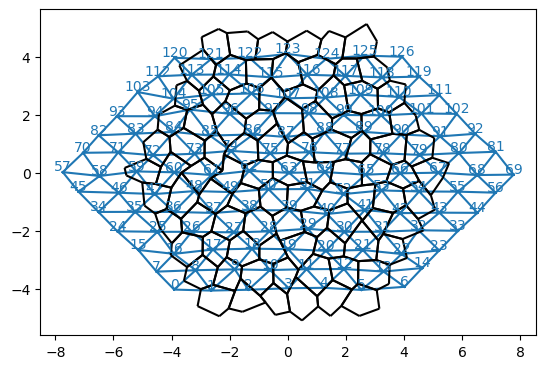

In [ ]:
## create a mesh and set initial conditions

mesh = CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0, ny=13, nx=13))

mesh.set_voronoi()
mesh.set_rest_lengths()
for v in mesh.vertices.values():
    v.rest_shape = np.sqrt(3)*np.eye(2)

mesh.transform_primal_vertices(lambda x: x+np.random.normal(size=2, scale=0.1))
mesh.transform_vertices(lambda x: dln.shear_mat(1.3)@x+np.random.normal(size=2, scale=0.05))

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
## define the boundaries. need to create boundary penalty functions and list the ids of boundary cells.

y_max = 4.3

def up_penalty(x):
    return (x[1]-y_max)**2
def down_penalty(x):
    return (x[1]+y_max)**2

# To allow JIT-compulattion, we need to wrap penalty function in jax.tree_util.Partial.
up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

# trigger compile
_ = up_penalty(np.array([1,1])), down_penalty(np.array([1,1]))

bdry_up = [up_penalty, [113, 114, 115, 116, 117, 118]] 
bdry_down = [down_penalty, [8, 9, 10, 11, 12, 13]]
bdry_list = (bdry_up, bdry_down)

In [ ]:
## set the elastic energy parameters

mod_bulk = 1
mod_shear = 0.5
angle_penalty = 1000
bdry_penalty = 1000

A0 = np.sqrt(3)/2
mod_area = 0

epsilon_l = 1e-3

In [ ]:
## illustrate patterning of elastic moduli - make the cells on the boundary softer

soft_ids = bdry_up[1]+bdry_down[1]
soft_mask = np.vectorize(lambda x: 1-.9*(x in soft_ids))(cell_list_vids)
mod_bulk_vec, mod_shear_vec = (mod_bulk*soft_mask, mod_shear*soft_mask)
# this makes the boundary cells 90% softer

In [ ]:
## serialize the mesh

x0 = mesh.dual_vertices_to_initial_cond()
get_E_arrays, cell_list_vids = mesh.get_primal_energy_fct_jax(bdry_list)


cell_shape_args = (mod_bulk_vec, mod_shear_vec, angle_penalty, bdry_penalty, epsilon_l, A0, mod_area)
#cell_shape_args = (mod_bulk, mod_shear, angle_penalty, bdry_penalty, epsilon_l, A0, mod_area)

In [ ]:
## example energy calculation

# note: the first evaluation triggers JIT compilation and can take a bit longer

_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args)) 

get_E(x0, *(get_E_arrays+cell_shape_args))

DeviceArray(105.53354735, dtype=float64)

In [ ]:
#| notest

%timeit get_E(x0, *(get_E_arrays+cell_shape_args))
%timeit get_E_jac(x0, *(get_E_arrays+cell_shape_args))

29.8 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
79 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
## optimize

%time sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,\
                              method="CG", tol=1e-4, options={"maxiter": 10000})

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print('final energy', sol["fun"])
print('initial/final energy', round(get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"]))

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.06 s
Optimization terminated successfully. n_eval:  5086 5086
final energy 0.09866428302828281
initial/final energy 1070


In [ ]:
## set new mesh coordinates

mesh_new = deepcopy(mesh)

new_coord_dict = mesh_new.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh_new.faces.items():
    val.dual_coords = new_coord_dict[key]

In [ ]:
## check that the angle penalty works as expected

print('pre opt.', round(np.quantile(list(mesh.get_angle_deviation().values()), .99), ndigits=4),
      'post opt.', round(np.quantile(list(mesh_new.get_angle_deviation().values()), .99), ndigits=4))

pre opt. 0.8004 post opt. 0.0035


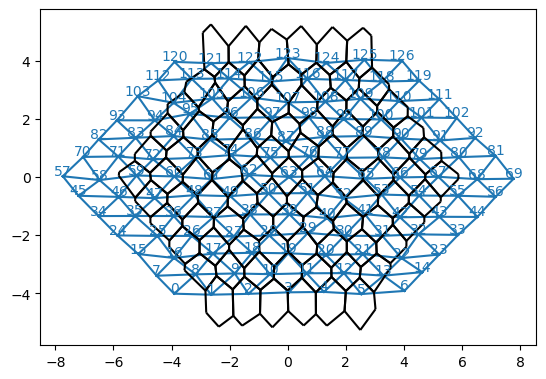

In [ ]:
## plot

mesh_new.cellplot()
mesh_new.triplot()
mesh_new.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");


### Optimization wrapper

Given that there is a lot of book-keeping involved, we wrap the above code in a single method.

In [ ]:
#| export

@patch
def optimize_cell_shape(self: CellHalfEdgeMesh, bdry_list=None,
                        energy_args=None, cell_id_to_modulus=None,
                        tol=1e-3, maxiter=10000, verbose=True, bdr_weight=2) -> None:
    """
    Set primal vertex positions by constrained cell-shape energy optimization.
    
    The parameters for the elastic energy (e.g. moduli) are passed as a dict 'energy_args'.
    bdry_list contains the boundary conditions, as pairs (penalty function, vertex ids).
    Also passes arguments to the scipy optimizer ('tol', 'maxiter')

    cell_id_to_modulus can be used to pattern the elastic moduli of the cells. It is a function
    that maps _vid -> [0, 1], i.e. vertex IDs to the strength of the elastic energy with 1=100%,
    and 0=no contribution of cell to elastic energy. All elastic moduli (shear, bulk, area)
    are multiplied with the same factor.
        
    Parameters
    ----------
    bdry_list: [(penalty function, vertex ids),]
        List of boundaries. None = no boundaries.
    energy_args: Dict
        Dictionary with the parameters to the cell shape elastic energy. Keys are:
            - mod_bulk = 1 : shape tensor bulk modulus
            - mod_shear = .5 : shape tensor shear modulus
            - angle_penalty = 1000 : angle constraint penalty
            - bdry_penalty = 1000 : boundary condition constraint penalty
            - epsilon_l = 1e-4 : regularization for small edge lengths
            - A0 = np.sqrt(3)/2 : reference area for area elasticity
            - mod_area = 0 : area elasticity modulus
    cell_id_to_modulus : callable
        Map vertex id -> relative elastic modulus. If None, all cells have the same moduli.
    tol: float
        Optimizer tolerance
    maxiter: int
        Maximum number of optimizer iterations
    verbose: bool
        Print error messages
    bdr_weight: float
        Slighly hacky: increase the weight of boundary cells in the elastic energy so that they do not
        collapse etc.
    
    Returns
    -------
    None
    
    """
    x0 = self.dual_vertices_to_initial_cond()
    get_E_arrays, cell_list_vids = self.get_primal_energy_fct_jax(bdry_list)

    if energy_args is None:
        energy_args = {"mod_bulk": 1, "mod_shear": .5, "angle_penalty": 1000, "bdry_penalty": 100,
                       "epsilon_l": 1e-4, "A0": jnp.sqrt(3)/2, "mod_area": 0}
    if cell_id_to_modulus is not None:
        mod_bulk = energy_args["mod_bulk"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
        mod_shear = energy_args["mod_shear"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
        mod_area = energy_args["mod_area"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
    else:
        mod_bulk, mod_shear, mod_area = (energy_args["mod_bulk"], energy_args["mod_shear"],
                                         energy_args["mod_area"])
    
    if bdr_weight != 1:
        is_bdr = np.array([any([fc.is_bdry() for fc in self.vertices[v].get_face_neighbors()])
                          for v in cell_list_vids])
        mod_bulk *= (bdr_weight*is_bdr+(1-is_bdr))
        mod_shear *= (bdr_weight*is_bdr+(1-is_bdr))
        mod_area *= (bdr_weight*is_bdr+(1-is_bdr))

    
    cell_shape_args = (mod_bulk, mod_shear, energy_args["angle_penalty"], energy_args["bdry_penalty"],
                       energy_args["epsilon_l"], energy_args["A0"], energy_args["mod_area"])
    
    sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                             method="CG", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

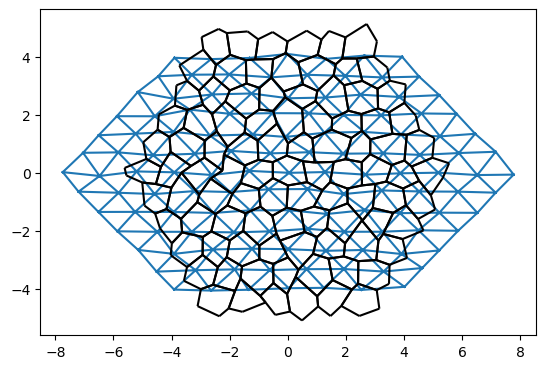

In [ ]:
## test this - use mesh from above

mesh_test = deepcopy(mesh)

mesh_test.cellplot()
mesh_test.triplot()
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
## set parameters

energy_args = {'mod_bulk': 1, 'mod_shear': .5, 'angle_penalty': 1000, 'bdry_penalty': 1000, 'mod_area': 0,
               'epsilon_l': 1e-3, 'A0': np.sqrt(3)/2}

cell_id_to_modulus = np.vectorize(lambda x: 1-.9*(x in soft_ids))

In [ ]:
mesh_test.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                              cell_id_to_modulus=cell_id_to_modulus,
                              tol=1e-3, maxiter=10000, verbose=True,)

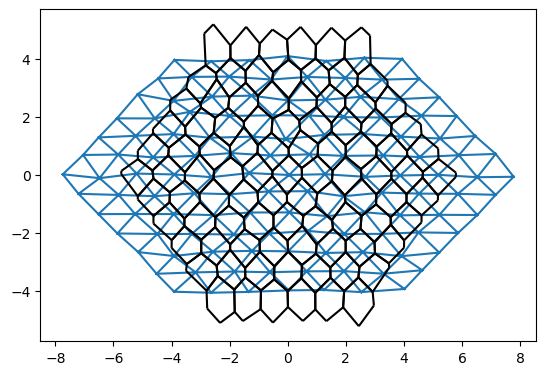

In [ ]:
mesh_test.cellplot()
mesh_test.triplot()
plt.gca().set_aspect("equal", adjustable="box");

### Intercalation handling

Handling intercalations is a bit more complicated than in the Delaunay case. Here, we define some helper functions.

We need to iterate over the short edges in the mesh, and flip them one by one. Since this can have non-local effects (different from Delaunay case), we re-optimize the shape at every step.

We also want to keep track of the edges flipped, so as to stop immediate re-flipping.

In [ ]:
#| export

def rotate_about_center(x: NDArray[Shape["*,2"],Float], angle=np.pi/2):
    """
    Rotate points about center of mass. x.shape = (n_pts, 2).
    
    Used to rotate vertex positions post T1 to get a better new initial condition.
    """
    center = np.mean(x, axis=0)
    return (x-center)@dln.rot_mat(angle)+center

In [ ]:
#| export

@patch
def get_flip_edge(self: CellHalfEdgeMesh, minimal_l: float, exclude: List[int]) -> Union[int, None]:
    """
    Gey key of the shortest primal edge in mesh if length < minimal_l and key not in exclude, else None.
    """
    
    primal_lengths = self.get_primal_edge_lens(oriented=True)
    primal_lengths = sorted(primal_lengths.items(), key=lambda x: x[1])
    primal_lengths = [x for x in primal_lengths if (x[1] <= minimal_l)]
    primal_lengths = [x for x in primal_lengths if not x[0] in exclude]
    if primal_lengths:
        return primal_lengths[0][0]
    return None

In [ ]:
#| export

@patch
def intercalate(self: CellHalfEdgeMesh, exclude: List[int], minimal_l: float,
                reoptimize=True, optimizer_args=None) -> Tuple[List, List]:
    """
    Intercalate short junctions and return list of (failed) intercalations.
    
    Iteratively flip edges shorter than minimal_l. After each edge flip,
    optionally re-run cell shape optimization. If so, need to pass the relevant
    arguments to self.optimize_cell_shape. Note: intercalations can fail if
    flipping would result in invalid mesh configs, e.g. flipping a boundary
    edge or an edge of a triangular cell.
    
    Parameters
    ----------
    exclude: list of ints
        list of half edge ids to exclude, e.g. edges which were flipped
        in a previous time step
    minimal_l: float
        Edges shorter than minimal_l are flipped
    reoptimize: bool
        Re-run shape optimization after each edge flip
    optimizer_args: dict
        Dictionary with the arguments for cell shape optimization, see
        docstring for self.optimize_cell_shape
            - bdry_list
            - energy_args
            - cell_id_to_modulus
            - tol, maxiter

    Returns
    -------
    flipped: list of int
        IDs of flipped edges
    failed_flip: list of int
        IDs of failed flips
    
    """
    optimizer_args = {} if optimizer_args is None else optimizer_args
    
    exclude = deepcopy(exclude)
    flipped = []
    failed_flip = []
    flip_edge = self.get_flip_edge(minimal_l, exclude)

    while flip_edge is not None:
        try:
            # flip and re-set the vertex coordinates
            he = self.hes[flip_edge]
            self.flip_edge(flip_edge)
            self.reset_rest_passive_flip(he, method="smooth")
            f0, f1 = (he.face, he.twin.face)
            f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
            # re-optimize
            if reoptimize:
                self.optimize_cell_shape(**optimizer_args)
            # log and choose next edge
            flipped.append(he._heid)
            exclude.append(he._heid)
            flip_edge = self.get_flip_edge(minimal_l, exclude)
            
        except ValueError:
            failed_flip.append(flip_edge)
            exclude.append(flip_edge)
            flip_edge = self.get_flip_edge(minimal_l, exclude)
            continue

    return flipped, failed_flip